In [4]:
!screenfetch

                          ./+o+-       ivb@cds2
                  yyyyy- -yyyyyy+      OS: Ubuntu 18.04 bionic
               ://+//////-yyyyyyo      Kernel: x86_64 Linux 4.15.0-74-generic
           .++ .:/++++++/-.+sss/`      Uptime: 3d 1h 25m
         .:++o:  /++++++++/:--:/-      Packages: 3045
        o:+o+:++.`..```.-/oo+++++/     Shell: sh
       .:+o:+o/.          `+sssoo+/    CPU: Intel Xeon Gold 6154 @ 16x 3GHz
  .++/+:+oo+o:`             /sssooo.   GPU: Tesla V100-SXM2-32GB, Tesla V100-SXM2-32GB, Tesla V100-SXM2-32GB, Tesla V100-SXM2-32GB
 /+++//+:`oo+o               /::--:.   RAM: 56517MiB / 128933MiB
 \+/+o+++`o++o               ++////.  
  .++.o+++oo+:`             /dddhhh.  
       .+.o+oo:.          `oddhhhh+   
        \+.++o+o``-````.:ohdhhhhh+    
         `:o+++ `ohhhhhhhhyo++os:     
           .o:`.syhhhhhhh/.oo++o`     
               /osyyyyyyo++ooo+++/    
                   ````` +oo+++o\:    
                          `oo++.      


In [5]:
# x -50 50
# y 0 50
# z 0 200

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import torch
import numpy as np
import json
import config as C
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from utils import parse_camera_intrinsic as parse_camera_intrinsic
from scipy.spatial.transform import Rotation as R
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms as T
from torch import nn
from tqdm import tqdm
import seaborn

In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [9]:
with open(C.TRAIN_CROPS_JSON, "r") as f:
    train_gt = json.load(f)

In [10]:
train_gt["annotations"][0]

{'id': 1,
 'image_id': 0,
 'category_id': 47,
 'bbox': [1723.0, 1776.0, 29.0, 26.0],
 'position': [3.8249, 31.7701, 168.57],
 'orientation': [0.0063812, -0.184722, 3.13912],
 'orientation_relative': [0.006918107352997232,
  -0.18451171371342667,
  3.139121365067781]}

In [11]:
p = parse_camera_intrinsic()
for k in p:
    p[k] = torch.from_numpy(np.array(p[k],dtype=np.float))

In [12]:
import io
class PKURegressionDataset(Dataset):
    
    def __init__(self, orientation_field, images_dir, max_size, transforms=None):
        super().__init__()
        self.orientation_field = orientation_field
        self.images_dir = images_dir
        self.max_size = max_size
        self.transforms = transforms
        
        with open(C.TRAIN_CROPS_JSON, "r") as f:
            self.gt = json.load(f)
        
        annotations =[]
        for i in range(len(self.gt['annotations'])):
            wx, wy, wz = self.gt['annotations'][i]['position']
            if ((-50<wx<50) and (0<wy<50) and (0<wz<200) and (np.sqrt(wx**2 + wy**2 +wz**2) < 100)):
                annotations.append(self.gt['annotations'][i])
        self.gt['annotations'] = annotations
    
        cat_ids = set(ann['category_id'] for ann in self.gt['annotations'])
        categories = [cat for cat in self.gt['categories'] if cat['id'] in cat_ids]
        self.category_id_to_label = {
            cat["id"]: label
            for label, cat in enumerate(sorted(categories, key=lambda x: x["id"]))
        }
        self.images_jpeg = self.load_images()
        
        self.p = parse_camera_intrinsic()
        for k in self.p:
            self.p[k] = float(self.p[k])
    
    def load_images(self):
        images = {}
        for image in tqdm(self.gt['images']):
            path = os.path.join(self.images_dir, image['file_name'])
            data = open(path, 'rb').read()
            images[image['id']] = io.BytesIO(data)
        return images
    
    def __len__(self):
        return len(self.gt["annotations"])
    
    def __getitem__(self, idx):
        image = self.load_image(idx)
        label = self.get_label(idx)
        bbox_x, bbox_y, bbox_w, bbox_h = self.get_bbox(idx)
        bbox_center_x, bbox_center_y = bbox_x + bbox_w / 2, bbox_y + bbox_h / 2
        wx, wy, wz = self.get_position(idx)
        orientation = self.get_orientation(idx)
        
        result =  dict(
            image=image,
            label=label,
            bbox=np.array([(bbox_center_x-self.p['cx'])/self.p['fx'], (bbox_center_y-self.p['cy'])/self.p['fy'], bbox_w/self.p['fx'], bbox_h/self.p['fy']]),
            position=np.array([wx, wy, wz]),
            distance=np.sqrt(wx**2 + wy**2 + wz**2),
            orientation=np.array(orientation)
            )
        if self.transforms is not None:
            result['image'] = self.transforms(result['image'])
        return result
    
    def load_image(self, idx):
        image_id = self.gt["annotations"][idx]["image_id"]
        image = self.decode_image(self.images_jpeg[image_id])
        w, h = image.size
        scale = self.max_size / max(w, h)
        w_new, h_new = int(w * scale), int(h * scale)
        image = image.resize((w_new, h_new), Image.LANCZOS)
        new_image = Image.new("RGB", (self.max_size, self.max_size))
        new_image.paste(image, ((self.max_size - w_new) // 2, (self.max_size - h_new) // 2))
        return new_image
        
    @staticmethod
    def decode_image(bytes_io):
        image = Image.open(bytes_io)
        image.load()
        return image
        
    def get_label(self, idx):
        return self.category_id_to_label[self.gt["annotations"][idx]["category_id"]]
    
    def get_bbox(self, idx):
        return self.gt["annotations"][idx]["bbox"]
    
    def get_position(self, idx):
        return self.gt["annotations"][idx]["position"]
    
    def get_orientation(self, idx):
        euler_angles = self.gt["annotations"][idx][self.orientation_field]
        rotation = R.from_euler("YXZ", euler_angles)
        q = rotation.as_quat()
        e = np.array([0,0,1])
        q[:3] = q[:3] * np.dot(e, q[:3]) / (np.abs(np.dot(q[:3], e)))
        return q

In [13]:
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [14]:
ds = PKURegressionDataset("orientation_relative", C.TRAIN_CROPS_CALIBRATED, 256, transforms)

100%|██████████| 49115/49115 [00:26<00:00, 1860.85it/s]


In [15]:
len(ds)

44277

In [16]:
r = ds[3]

In [17]:
r["image"].shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


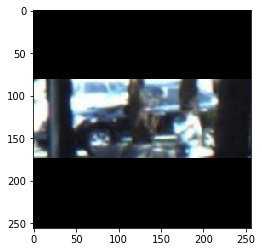

In [18]:
plt.imshow((np.transpose(r["image"].numpy(), (1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])))

In [19]:
r

{'image': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044,

In [20]:
dl = DataLoader(ds, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)

In [21]:
for batch in dl:
    break

print(batch)

In [19]:
len(ds.category_id_to_label)

34

In [20]:
batch['image'].shape

torch.Size([64, 3, 256, 256])

In [21]:
rad_power = 6

In [22]:
class ConvBnAct(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(inplace=True)
        
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        nn.init.constant_(self.conv.bias, 0)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet101(pretrained=True)
        
        self.local_neck = nn.Sequential(
            ConvBnAct(2048, 512),
            ConvBnAct(512, 256),
            ConvBnAct(256, 64),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 1024),  # 4
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 1024),  # 6
            nn.LeakyReLU(inplace=True)
        )
        nn.init.kaiming_normal_(self.local_neck[4].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.local_neck[4].bias, 0)
        nn.init.kaiming_normal_(self.local_neck[6].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.local_neck[6].bias, 0)
        
        self.cls_head = nn.Linear(1024, 34)
        nn.init.kaiming_normal_(self.cls_head.weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.cls_head.bias, 0)
        
        self.rot_head = nn.Linear(1024, 4)
        nn.init.kaiming_normal_(self.rot_head.weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.rot_head.bias, 0)
        
        self.trans_ass = nn.Sequential(
            nn.Linear(rad_power,1,bias=False)    
        )
        nn.init.xavier_normal_(self.trans_ass[0].weight)
        
        
        self.trans_neck = nn.Sequential(
             nn.Linear(1024, 128),  # 0
             nn.LeakyReLU(inplace=True)#,
#             nn.Linear(100, 100),  # 2
#             nn.LeakyReLU(inplace=True),
        )
        nn.init.kaiming_normal_(self.trans_neck[0].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.trans_neck[0].bias, 0)
#         nn.init.kaiming_normal_(self.trans_neck[2].weight, nonlinearity='leaky_relu')
#         nn.init.constant_(self.trans_neck[2].bias, 0)
        
#         self.ln_to_trans = nn.Sequential(
#             nn.Linear(1024, 100),  # 0
#             nn.LeakyReLU(inplace=True)
#         )
#         nn.init.kaiming_normal_(self.ln_to_trans[0].weight, nonlinearity='leaky_relu')
#         nn.init.constant_(self.ln_to_trans[0].bias, 0)
        self.size_neck = nn.Sequential(
            nn.Linear(2,128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128,128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128,128),
            nn.LeakyReLU(inplace=True)
        )
        nn.init.kaiming_normal_(self.size_neck[0].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.size_neck[0].bias, 0)
        nn.init.kaiming_normal_(self.size_neck[2].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.size_neck[2].bias, 0)
        nn.init.kaiming_normal_(self.size_neck[4].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.size_neck[4].bias, 0)
    
        self.trans_head = nn.Linear(256, 1)
        nn.init.xavier_normal_(self.trans_head.weight)
        nn.init.constant_(self.trans_head.bias, 0)
        
    def extract_features(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        return x
    
    def forward(self, x,bbox):
        features = self.extract_features(x)
        ln = self.local_neck(features)
        tn = self.trans_neck(ln)
        rad = torch.sqrt(torch.pow(bbox[:,0:1],2) + torch.pow(bbox[:,1:2],2))
        rad_powers = rad
        for i in range(1,rad_power):
            rad_powers = torch.cat((rad_powers,torch.pow(rad,i+1)),dim=-1 )
#         print(rad_powers.shape)    
        ta = 1 + self.trans_ass(rad_powers)
                            
#         translation_v1 = self.trans_neck(bbox)
#         ln_to_trans_n = self.ln_to_trans(ln)
#         #rint((translation_v1.shape,ln_to_trans_n.shape))
        
        sn = self.size_neck(bbox[:,2:])
        
        distance = self.trans_head(torch.cat((sn,tn),dim = -1))
        
        distance_scaled = distance*ta
        
        cls_score = self.cls_head(ln)
        orientation = self.rot_head(ln)
        
        return dict(cls_score=cls_score, orientation = orientation, distance = distance_scaled)

In [23]:
model = Model()

In [24]:
#sum(p.nelement() for p in model.parameters())

In [25]:
#sum(p.nelement() for p in model.backbone.parameters())

outputs = model(batch['image'])

outputs

 torch.norm(outputs['orientation'], dim=-1, keepdim=True)

In [26]:
def huber_loss(bbox_pred, bbox_targets, beta=2.8):
    """
    SmoothL1(x) = 0.5 * x^2 / beta      if |x| < beta
                  |x| - 0.5 * beta      otherwise.
    https://en.wikipedia.org/wiki/Huber_loss
    """
    box_diff = bbox_pred - bbox_targets

    dis_trans = torch.norm(box_diff, dim=1)
    # dis_trans = np.linalg.norm(box_diff.data.cpu().numpy(), axis=1)
    # we also add a metric for dist<2.8 metres.
    inbox_idx = dis_trans <= 2.8
    outbox_idx = dis_trans > 2.8

    # bbox_inside_weights = torch.from_numpy(inbox_idx.astype('float32')).cuda()
    # bbox_outside_weights = torch.from_numpy(outbox_idx.astype('float32')).cuda()
    bbox_inside_weights = inbox_idx.float()
    bbox_outside_weights = outbox_idx.float()

    in_box_pow_diff = 0.5 * torch.pow(box_diff, 2) / beta
    in_box_loss = in_box_pow_diff.sum(dim=1) * bbox_inside_weights

    out_box_abs_diff = torch.abs(box_diff)
    out_box_loss = (out_box_abs_diff.sum(dim=1) - beta / 2) * bbox_outside_weights

    loss_box = in_box_loss + out_box_loss
    N = loss_box.size(0)  # batch size
    loss_box = loss_box.view(-1).sum(0) / N
    return loss_box

In [27]:
def dist_to_coord(outputs, batch):
#     print(outputs['distance'])
    z_outputs = outputs['distance']*torch.sqrt(1/torch.reshape(1+torch.pow(batch['bbox'][:,0],2)+torch.pow(batch['bbox'][:,1],2),(64,1)))
    x_outputs = torch.reshape(batch['bbox'][:,0],(64,1))*z_outputs
    y_outputs = torch.reshape(batch['bbox'][:,1],(64,1))*z_outputs
#     print(torch.cat((x_outputs,y_outputs,z_outputs),dim = -1))
    return torch.cat((x_outputs,y_outputs,z_outputs),dim = -1)

def dist_to_coord(outputs, batch):
#     print(outputs['distance'])
    z_outputs = outputs['distance']*torch.sqrt(1/torch.reshape(1+torch.pow((batch['bbox'][:,0]-p['cx'])/p['fx'],2)+torch.pow((batch['bbox'][:,1]-p['cy'])/p['fy'],2),(64,1)))
    x_outputs = torch.reshape((batch['bbox'][:,0]-p['cx'])/p['fx'],(64,1))*z_outputs
    y_outputs = torch.reshape((batch['bbox'][:,1]-p['cy'])/p['fy'],(64,1))*z_outputs
#     print(torch.cat((x_outputs,y_outputs,z_outputs),dim = -1))
    return torch.cat((x_outputs,y_outputs,z_outputs),dim = -1)

In [28]:
def mean_distance(batch,outputs):
    dist_to_coord(outputs,batch),batch['position']
    distance = torch.sqrt(torch.pow((dist_to_coord(outputs,batch)-batch['position']),2).sum(dim=1)).mean()
    return distance

In [29]:
def loss_fn(outputs, batch):
    cls_loss = nn.functional.cross_entropy(outputs['cls_score'], batch['label'])
    normed = outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True)
    
#     e = torch.FloatTensor([0, 0, 1]).cuda()
#     prod = (normed[:, :3] * e).sum(dim=1)
#     normed2 = torch.cat((torch.unsqueeze(prod / torch.abs(prod), 1) * normed[:, :3], normed[:, 3:4]), dim=1)
#     trans_loss = huber_loss(outputs['translation'],batch['position'])

    rot_loss_old = nn.functional.l1_loss(normed, batch['orientation'])
    
    rot_loss = 1-(normed[:, -1] * batch['orientation'][:, -1] + \
               (normed[:, :-1] * batch['orientation'][:, :-1]).sum(dim=1)).mean()
    trans_loss = huber_loss(dist_to_coord(outputs,batch),batch['position'])
#     distance_loss = huber_loss(outputs['distance'],batch['distance'])
    true_distance = mean_distance(batch,outputs)
    loss =  rot_loss + 0.1*trans_loss + cls_loss 
    return dict(loss=loss, cls_loss=rot_loss_old, rot_loss = rot_loss, trans_loss = trans_loss, true_distance = true_distance)

In [30]:
model = model.cuda()

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

sd = optimizer.state_dict()
sd['param_groups'][0]['lr'] = sd['param_groups'][0]['lr']/2
optimizer.load_state_dict(sd)

sd['param_groups'][0]['lr']

model.load_state_dict(torch.load("model_16-01-16:35.pth"))
optimizer.load_state_dict(torch.load("optim_16-01-16:35.pth"))

In [32]:
losses = []

In [33]:
pbar = tqdm(total=len(dl))

  0%|          | 0/691 [00:00<?, ?it/s]

In [34]:
def smooth(beta, array):
    s=[]
    s.append(array[0])
    for i in range(1,len(array)):
        s.append((1-beta)*s[-1]+beta*array[i])
    return s

In [35]:
from IPython.display import clear_output

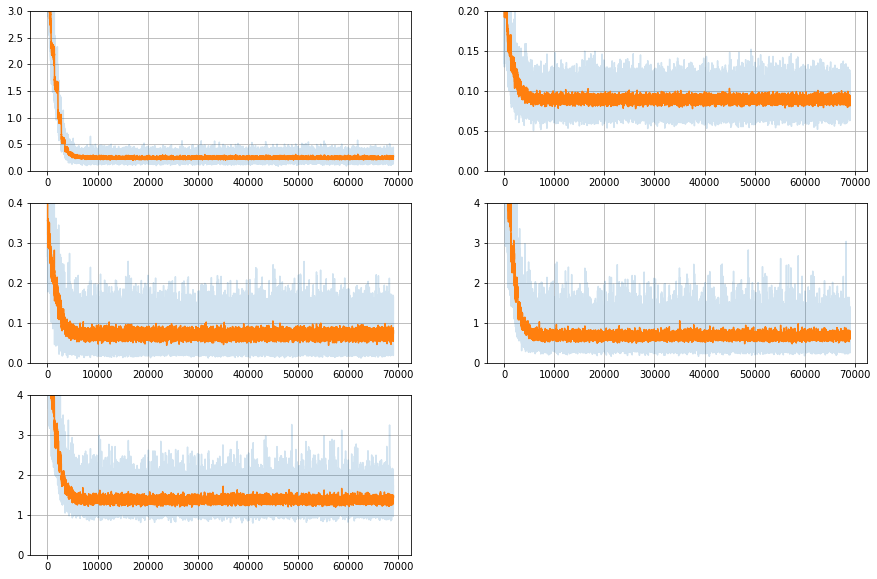

0.31198 0.08522 0.07435 0.89064 1.49805: : 69100it [8:57:53,  2.28it/s]

In [36]:
#pbar = tqdm(total=len(dl))
for i in range(100):
    for j, batch in enumerate(dl):
        for k in batch:
            if k == 'label':
                batch[k] = batch[k].long()
            else:
                batch[k] = batch[k].float()
            batch[k] = batch[k].cuda()
        outputs = model(batch['image'],batch['bbox'])
        loss = loss_fn(outputs, batch)
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()
        for k in loss:
            loss[k] = loss[k].item()
        losses.append(loss)
        pbar.update()
        pbar.set_description("{:.5f} {:.5f} {:.5f} {:.5f} {:.5f}".format(loss['loss'], loss['cls_loss'], loss['rot_loss'], loss['trans_loss'], loss['true_distance']))
        if j % 200 == 0:
            clear_output()
            plt.figure(figsize=[15, 10])
            plt.subplot(3, 2, 1)
            plt.plot([l["loss"] for l in losses], alpha=0.2) #second epoch lr =1e-4
            plt.plot(smooth(0.1, [l["loss"] for l in losses]))
            plt.ylim((0,3))
            plt.grid()
            plt.subplot(3, 2, 2)
            plt.plot([l["cls_loss"] for l in losses], alpha=0.2) #second epoch lr =1e-4
            plt.plot(smooth(0.1, [l["cls_loss"] for l in losses]))
            plt.ylim((0,0.2))
            plt.grid()
            plt.subplot(3, 2, 3)
            plt.plot([l["rot_loss"] for l in losses], alpha=0.2) #second epoch lr =1e-4
            plt.plot(smooth(0.1, [l["rot_loss"] for l in losses]))
            plt.ylim((0,0.4))
            plt.grid()
            plt.subplot(3, 2, 4)
            plt.plot([l["trans_loss"] for l in losses], alpha=0.2) #second epoch lr =1e-4
            plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
            plt.ylim((0,4))
            plt.grid()
            plt.subplot(3, 2, 5)
            plt.plot([l["true_distance"] for l in losses if 'true_distance' in l], alpha=0.2) #second epoch lr =1e-4
            plt.plot(smooth(0.1, [l["true_distance"] for l in losses if 'true_distance' in l]))
            plt.ylim((0,4))
            plt.grid()
            plt.show()
    sd = optimizer.state_dict()
    sd['param_groups'][0]['lr'] = sd['param_groups'][0]['lr']/2
    optimizer.load_state_dict(sd)

model.load_state_dict(torch.load("stupid_1501_model.pth"))

In [37]:
%autoreload 0

In [89]:
torch.save(model.state_dict(), "model_regressor-with_r-nl-Copy2_17-01-13:00.pth") 
torch.save(optimizer.state_dict(), "optim_regressor-with_r-nl-Copy2_17-01-13:00.pth")

model.load_state_dict(torch.load("model_16-01-11:11.pth"))

In [81]:
pbar = tqdm(total=len(dl))
s = 0
for batch in dl:
    for k in batch:
        if k == 'label':
            batch[k] = batch[k].long()
        else:
            batch[k] = batch[k].float()
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(batch['image'],batch['bbox'])
    dis_trans = torch.norm(batch['position'] - dist_to_coord(outputs,batch), dim=1)
    s += (dis_trans < 0.1).long().sum().item()
    pbar.update()
print(s / len(ds))












  0%|          | 0/691 [00:00<?, ?it/s]










  0%|          | 1/691 [00:00<09:32,  1.20it/s]










  0%|          | 2/691 [00:00<07:07,  1.61it/s]










  0%|          | 3/691 [00:01<05:57,  1.92it/s]










  1%|          | 4/691 [00:01<04:37,  2.48it/s]










  1%|          | 5/691 [00:01<04:20,  2.63it/s]










  1%|          | 6/691 [00:01<03:33,  3.21it/s]










  1%|          | 7/691 [00:02<03:43,  3.06it/s]










  1%|          | 8/691 [00:02<03:07,  3.64it/s]










  1%|▏         | 9/691 [00:02<02:54,  3.90it/s]










  1%|▏         | 10/691 [00:02<02:34,  4.41it/s]










  2%|▏         | 11/691 [00:02<02:19,  4.89it/s]










  2%|▏         | 12/691 [00:03<02:04,  5.46it/s]










  2%|▏         | 13/691 [00:03<01:55,  5.85it/s]










  2%|▏         | 14/691 [00:03<01:49,  6.17it/s]










  2%|▏         | 15/691 [00:03<01:44,  6.48it/s]










  2%|▏         | 16/691 [00:03<01:55,  5.84it/s]










  2%

 26%|██▌       | 177/691 [00:31<01:13,  6.95it/s]










 26%|██▌       | 178/691 [00:31<01:18,  6.50it/s]










 26%|██▌       | 179/691 [00:31<01:16,  6.66it/s]










 26%|██▌       | 180/691 [00:32<01:26,  5.92it/s]










 26%|██▌       | 181/691 [00:32<01:22,  6.22it/s]










 26%|██▋       | 182/691 [00:32<01:19,  6.43it/s]










 26%|██▋       | 183/691 [00:32<01:17,  6.57it/s]










 27%|██▋       | 184/691 [00:32<01:15,  6.69it/s]










 27%|██▋       | 185/691 [00:32<01:14,  6.78it/s]










 27%|██▋       | 186/691 [00:32<01:15,  6.65it/s]










 27%|██▋       | 187/691 [00:33<01:14,  6.77it/s]










 27%|██▋       | 188/691 [00:33<01:13,  6.87it/s]










 27%|██▋       | 189/691 [00:33<01:12,  6.96it/s]










 27%|██▋       | 190/691 [00:33<01:12,  6.94it/s]










 28%|██▊       | 191/691 [00:33<01:10,  7.12it/s]










 28%|██▊       | 192/691 [00:33<01:09,  7.18it/s]










 28%|██▊       | 193/691 [00:33<01:07,  

 51%|█████     | 353/691 [00:57<00:48,  7.03it/s]










 51%|█████     | 354/691 [00:57<00:47,  7.15it/s]










 51%|█████▏    | 355/691 [00:57<00:46,  7.24it/s]










 52%|█████▏    | 356/691 [00:57<00:47,  7.01it/s]










 52%|█████▏    | 357/691 [00:58<00:47,  7.09it/s]










 52%|█████▏    | 358/691 [00:58<00:48,  6.85it/s]










 52%|█████▏    | 359/691 [00:58<00:49,  6.64it/s]










 52%|█████▏    | 360/691 [00:58<00:48,  6.78it/s]










 52%|█████▏    | 361/691 [00:58<00:54,  6.00it/s]










 52%|█████▏    | 362/691 [00:58<00:53,  6.12it/s]










 53%|█████▎    | 363/691 [00:59<01:09,  4.70it/s]










 53%|█████▎    | 364/691 [00:59<01:04,  5.05it/s]










 53%|█████▎    | 365/691 [00:59<01:00,  5.40it/s]










 53%|█████▎    | 366/691 [00:59<00:56,  5.76it/s]










 53%|█████▎    | 367/691 [00:59<00:52,  6.22it/s]










 53%|█████▎    | 368/691 [01:00<00:49,  6.56it/s]










 53%|█████▎    | 369/691 [01:00<00:47,  

 77%|███████▋  | 529/691 [01:26<00:26,  6.06it/s]










 77%|███████▋  | 530/691 [01:26<00:28,  5.75it/s]










 77%|███████▋  | 531/691 [01:26<00:25,  6.17it/s]










 77%|███████▋  | 532/691 [01:27<00:37,  4.26it/s]










 77%|███████▋  | 533/691 [01:27<00:33,  4.69it/s]










 77%|███████▋  | 534/691 [01:27<00:29,  5.25it/s]










 77%|███████▋  | 535/691 [01:27<00:27,  5.74it/s]










 78%|███████▊  | 536/691 [01:28<00:35,  4.31it/s]










 78%|███████▊  | 537/691 [01:28<00:31,  4.89it/s]










 78%|███████▊  | 538/691 [01:28<00:30,  4.97it/s]










 78%|███████▊  | 539/691 [01:28<00:27,  5.47it/s]










 78%|███████▊  | 540/691 [01:28<00:36,  4.19it/s]










 78%|███████▊  | 541/691 [01:29<00:30,  4.85it/s]










 78%|███████▊  | 542/691 [01:29<00:34,  4.28it/s]










 79%|███████▊  | 543/691 [01:29<00:30,  4.89it/s]










 79%|███████▊  | 544/691 [01:29<00:28,  5.17it/s]










 79%|███████▉  | 545/691 [01:29<00:25,  

0.020326580391625448


In [86]:
pbar = tqdm(total=len(dl))
s = 0
for batch in dl:
    for k in batch:
        if k == 'label':
            batch[k] = batch[k].long()
        else:
            batch[k] = batch[k].float()
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(batch['image'],batch['bbox'])
    dis_trans = torch.norm(batch['position'] - dist_to_coord(outputs,batch), dim=1)
    s += (dis_trans < 0.01*batch['distance']).long().sum().item()
    pbar.update()
print(s / len(ds))

















  0%|          | 0/691 [00:00<?, ?it/s]















  0%|          | 1/691 [00:00<07:19,  1.57it/s]















  0%|          | 2/691 [00:00<05:36,  2.04it/s]















  0%|          | 3/691 [00:01<04:41,  2.44it/s]















  1%|          | 4/691 [00:01<03:45,  3.04it/s]















  1%|          | 5/691 [00:01<03:25,  3.34it/s]















  1%|          | 6/691 [00:01<03:29,  3.27it/s]















  1%|          | 7/691 [00:01<03:02,  3.75it/s]















  1%|          | 8/691 [00:02<02:59,  3.81it/s]















  1%|▏         | 9/691 [00:02<02:33,  4.46it/s]















  1%|▏         | 10/691 [00:02<02:42,  4.20it/s]















  2%|▏         | 11/691 [00:02<02:20,  4.84it/s]















  2%|▏         | 12/691 [00:02<02:45,  4.11it/s]















  2%|▏         | 13/691 [00:03<02:27,  4.60it/s]















  2%|▏         | 14/691 [00:03<02:11,  5.15it/s]















  2%|▏         | 15/691 [00:03<01:59,  5.6

 21%|██        | 145/691 [00:25<01:17,  7.00it/s]















 21%|██        | 146/691 [00:25<01:26,  6.34it/s]















 21%|██▏       | 147/691 [00:25<01:22,  6.57it/s]















 21%|██▏       | 148/691 [00:25<01:24,  6.42it/s]















 22%|██▏       | 149/691 [00:25<01:25,  6.36it/s]















 22%|██▏       | 150/691 [00:26<01:21,  6.61it/s]















 22%|██▏       | 151/691 [00:26<01:18,  6.88it/s]















 22%|██▏       | 152/691 [00:26<01:19,  6.79it/s]















 22%|██▏       | 153/691 [00:26<01:16,  6.99it/s]















 22%|██▏       | 154/691 [00:26<01:14,  7.18it/s]















 22%|██▏       | 155/691 [00:26<01:17,  6.90it/s]















 23%|██▎       | 156/691 [00:26<01:20,  6.69it/s]















 23%|██▎       | 157/691 [00:27<01:16,  6.94it/s]















 23%|██▎       | 158/691 [00:27<01:14,  7.12it/s]















 23%|██▎       | 159/691 [00:27<01:13,  7.27it/s]















 23%|██▎       | 160/691 

 42%|████▏     | 289/691 [00:46<01:14,  5.40it/s]















 42%|████▏     | 290/691 [00:46<01:07,  5.92it/s]















 42%|████▏     | 291/691 [00:47<01:03,  6.29it/s]















 42%|████▏     | 292/691 [00:47<01:00,  6.56it/s]















 42%|████▏     | 293/691 [00:47<00:58,  6.85it/s]















 43%|████▎     | 294/691 [00:47<00:56,  6.98it/s]















 43%|████▎     | 295/691 [00:47<00:55,  7.15it/s]















 43%|████▎     | 296/691 [00:47<00:56,  6.95it/s]















 43%|████▎     | 297/691 [00:48<01:03,  6.24it/s]















 43%|████▎     | 298/691 [00:48<01:01,  6.41it/s]















 43%|████▎     | 299/691 [00:48<01:12,  5.44it/s]















 43%|████▎     | 300/691 [00:48<01:08,  5.72it/s]















 44%|████▎     | 301/691 [00:48<01:32,  4.21it/s]















 44%|████▎     | 302/691 [00:49<01:20,  4.83it/s]















 44%|████▍     | 303/691 [00:49<01:24,  4.61it/s]















 44%|████▍     | 304/691 

 63%|██████▎   | 433/691 [01:10<00:46,  5.51it/s]















 63%|██████▎   | 434/691 [01:10<00:42,  5.99it/s]















 63%|██████▎   | 435/691 [01:10<00:47,  5.35it/s]















 63%|██████▎   | 436/691 [01:10<00:45,  5.66it/s]















 63%|██████▎   | 437/691 [01:11<00:45,  5.56it/s]















 63%|██████▎   | 438/691 [01:11<00:42,  5.96it/s]















 64%|██████▎   | 439/691 [01:11<00:39,  6.37it/s]















 64%|██████▎   | 440/691 [01:11<00:38,  6.52it/s]















 64%|██████▍   | 441/691 [01:11<00:45,  5.55it/s]















 64%|██████▍   | 442/691 [01:11<00:42,  5.93it/s]















 64%|██████▍   | 443/691 [01:12<00:49,  4.99it/s]















 64%|██████▍   | 444/691 [01:12<00:45,  5.43it/s]















 64%|██████▍   | 445/691 [01:12<00:52,  4.68it/s]















 65%|██████▍   | 446/691 [01:12<00:46,  5.29it/s]















 65%|██████▍   | 447/691 [01:12<00:42,  5.77it/s]















 65%|██████▍   | 448/691 

 84%|████████▎ | 577/691 [01:34<00:18,  6.15it/s]















 84%|████████▎ | 578/691 [01:34<00:18,  6.22it/s]















 84%|████████▍ | 579/691 [01:34<00:20,  5.37it/s]















 84%|████████▍ | 580/691 [01:35<00:19,  5.74it/s]















 84%|████████▍ | 581/691 [01:35<00:23,  4.70it/s]















 84%|████████▍ | 582/691 [01:35<00:20,  5.29it/s]















 84%|████████▍ | 583/691 [01:35<00:18,  5.82it/s]















 85%|████████▍ | 584/691 [01:35<00:17,  6.14it/s]















 85%|████████▍ | 585/691 [01:36<00:19,  5.55it/s]















 85%|████████▍ | 586/691 [01:36<00:17,  5.97it/s]















 85%|████████▍ | 587/691 [01:36<00:19,  5.40it/s]















 85%|████████▌ | 588/691 [01:36<00:17,  5.88it/s]















 85%|████████▌ | 589/691 [01:36<00:17,  5.72it/s]















 85%|████████▌ | 590/691 [01:36<00:16,  6.13it/s]















 86%|████████▌ | 591/691 [01:37<00:21,  4.76it/s]















 86%|████████▌ | 592/691 

0.19317026898841386


In [72]:
pbar = tqdm(total=len(dl))
real_distance = []
predicted_distance = []
dcoord =[]
s=0
for batch in dl:
    for k in batch:
        if k == 'label':
            batch[k] = batch[k].long()
        else:
            batch[k] = batch[k].float()
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(batch['image'],batch['bbox'])
    dis_trans = torch.norm(batch['position'] - dist_to_coord(outputs,batch), dim=1)
    dcoord.append((batch['position'] - dist_to_coord(outputs,batch)).detach().cpu().numpy())
    real_distance.append(batch['distance'].detach().cpu().numpy())
    predicted_distance.append(outputs['distance'].detach().cpu().numpy())
    s += (dis_trans < 0.1).long().sum().item()
    pbar.update()
print(s / len(ds))










  0%|          | 0/691 [00:00<?, ?it/s]








  0%|          | 1/691 [00:00<08:01,  1.43it/s]








  0%|          | 2/691 [00:00<06:10,  1.86it/s]








  0%|          | 3/691 [00:00<04:45,  2.41it/s]








  1%|          | 4/691 [00:01<03:56,  2.91it/s]








  1%|          | 5/691 [00:01<03:18,  3.46it/s]








  1%|          | 6/691 [00:01<02:45,  4.14it/s]








  1%|          | 7/691 [00:01<02:22,  4.79it/s]








  1%|          | 8/691 [00:01<02:07,  5.34it/s]








  1%|▏         | 9/691 [00:02<02:24,  4.72it/s]








  1%|▏         | 10/691 [00:02<02:14,  5.06it/s]








  2%|▏         | 11/691 [00:02<02:30,  4.51it/s]








  2%|▏         | 12/691 [00:02<02:13,  5.08it/s]








  2%|▏         | 13/691 [00:02<02:03,  5.50it/s]








  2%|▏         | 14/691 [00:03<02:46,  4.08it/s]








  2%|▏         | 15/691 [00:03<02:27,  4.58it/s]








  2%|▏         | 16/691 [00:03<02:22,  4.72it/s]








  2%|▏         | 17/691 [00:03<02:09,  5

 28%|██▊       | 193/691 [00:32<01:14,  6.70it/s]








 28%|██▊       | 194/691 [00:32<01:12,  6.90it/s]








 28%|██▊       | 195/691 [00:32<01:18,  6.34it/s]








 28%|██▊       | 196/691 [00:32<01:17,  6.40it/s]








 29%|██▊       | 197/691 [00:33<01:30,  5.48it/s]








 29%|██▊       | 198/691 [00:33<01:24,  5.86it/s]








 29%|██▉       | 199/691 [00:33<01:19,  6.18it/s]








 29%|██▉       | 200/691 [00:33<01:17,  6.31it/s]








 29%|██▉       | 201/691 [00:33<01:15,  6.53it/s]








 29%|██▉       | 202/691 [00:33<01:12,  6.71it/s]








 29%|██▉       | 203/691 [00:34<01:10,  6.97it/s]








 30%|██▉       | 204/691 [00:34<01:09,  7.02it/s]








 30%|██▉       | 205/691 [00:34<01:11,  6.82it/s]








 30%|██▉       | 206/691 [00:34<01:09,  6.96it/s]








 30%|██▉       | 207/691 [00:34<01:23,  5.79it/s]








 30%|███       | 208/691 [00:34<01:17,  6.21it/s]








 30%|███       | 209/691 [00:35<01:33,  5.14it/s]








 30%|███      

 56%|█████▌    | 385/691 [01:05<00:50,  6.09it/s]








 56%|█████▌    | 386/691 [01:06<00:47,  6.42it/s]








 56%|█████▌    | 387/691 [01:06<00:45,  6.73it/s]








 56%|█████▌    | 388/691 [01:06<00:50,  5.98it/s]








 56%|█████▋    | 389/691 [01:06<00:47,  6.39it/s]








 56%|█████▋    | 390/691 [01:06<01:02,  4.82it/s]








 57%|█████▋    | 391/691 [01:06<00:56,  5.32it/s]








 57%|█████▋    | 392/691 [01:07<00:56,  5.33it/s]








 57%|█████▋    | 393/691 [01:07<00:51,  5.81it/s]








 57%|█████▋    | 394/691 [01:07<00:49,  6.04it/s]








 57%|█████▋    | 395/691 [01:07<00:47,  6.25it/s]








 57%|█████▋    | 396/691 [01:07<00:46,  6.34it/s]








 57%|█████▋    | 397/691 [01:07<00:45,  6.41it/s]








 58%|█████▊    | 398/691 [01:08<00:43,  6.72it/s]








 58%|█████▊    | 399/691 [01:08<00:43,  6.76it/s]








 58%|█████▊    | 400/691 [01:08<00:41,  6.94it/s]








 58%|█████▊    | 401/691 [01:08<00:40,  7.09it/s]








 58%|█████▊   

 84%|████████▎ | 577/691 [01:34<00:16,  7.11it/s]








 84%|████████▎ | 578/691 [01:34<00:15,  7.10it/s]








 84%|████████▍ | 579/691 [01:34<00:22,  4.88it/s]








 84%|████████▍ | 580/691 [01:34<00:20,  5.37it/s]








 84%|████████▍ | 581/691 [01:35<00:21,  5.14it/s]








 84%|████████▍ | 582/691 [01:35<00:19,  5.55it/s]








 84%|████████▍ | 583/691 [01:35<00:18,  5.68it/s]








 85%|████████▍ | 584/691 [01:35<00:17,  6.07it/s]








 85%|████████▍ | 585/691 [01:35<00:16,  6.42it/s]








 85%|████████▍ | 586/691 [01:35<00:15,  6.56it/s]








 85%|████████▍ | 587/691 [01:35<00:15,  6.71it/s]








 85%|████████▌ | 588/691 [01:36<00:14,  6.88it/s]








 85%|████████▌ | 589/691 [01:36<00:14,  7.03it/s]








 85%|████████▌ | 590/691 [01:36<00:14,  7.03it/s]








 86%|████████▌ | 591/691 [01:36<00:14,  6.81it/s]








 86%|████████▌ | 592/691 [01:36<00:14,  6.97it/s]








 86%|████████▌ | 593/691 [01:36<00:15,  6.41it/s]








 86%|████████▌

0.021410664679178806


In [77]:
real_distance_numpy = real_distance[0]
dcoord_numpy = dcoord[0]
predicted_distance_numpy = predicted_distance[0]
for i in range(1,len(real_distance)):
    real_distance_numpy = np.concatenate((real_distance_numpy,real_distance[i]), axis = 0)
    dcoord_numpy = np.concatenate((dcoord_numpy, dcoord[i]), axis = 0)
    predicted_distance_numpy = np.concatenate((predicted_distance_numpy, predicted_distance[i]), axis = 0)
print(real_distance_numpy.shape)
print(dcoord_numpy.shape)
print(predicted_distance_numpy.shape)

(44224,)
(44224, 3)
(44224, 1)


In [78]:
import pandas as pd
dic = {'real_distance':real_distance_numpy,'predicted_distance':predicted_distance_numpy.reshape((dcoord_numpy.shape[0],)), 'x':dcoord_numpy[:,0].reshape((dcoord_numpy.shape[0],)), 'y':dcoord_numpy[:,1].reshape((dcoord_numpy.shape[0],)), 'z':dcoord_numpy[:,2].reshape((dcoord_numpy.shape[0],))}
df = pd.DataFrame(dic)

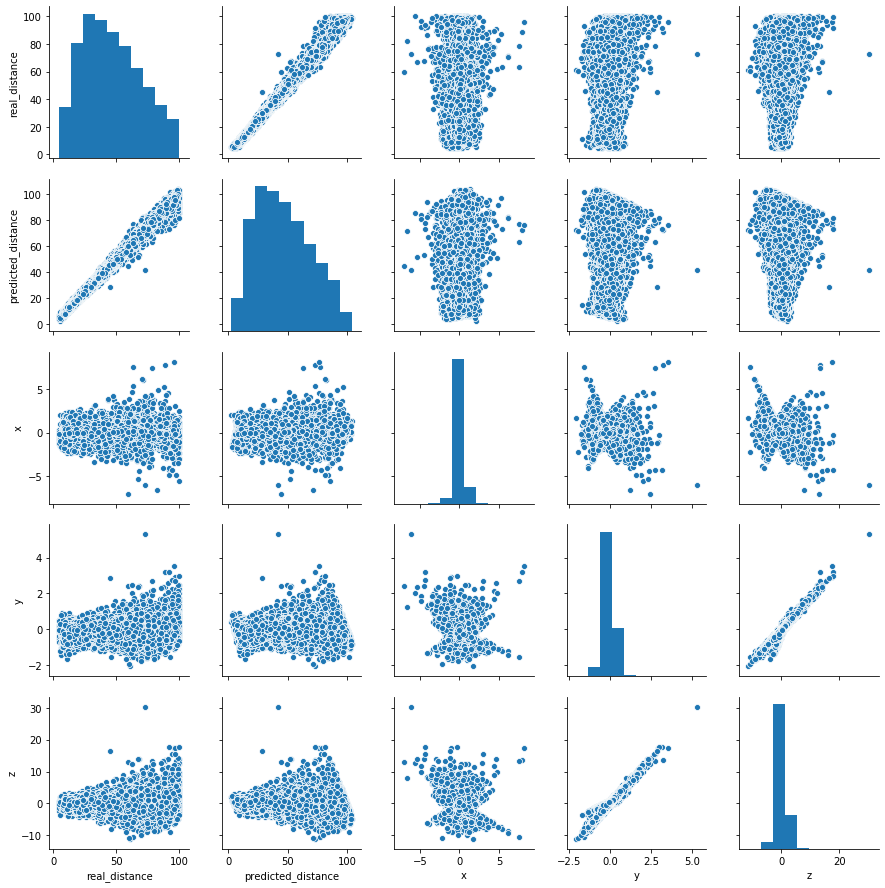

In [79]:
seaborn.pairplot(df)

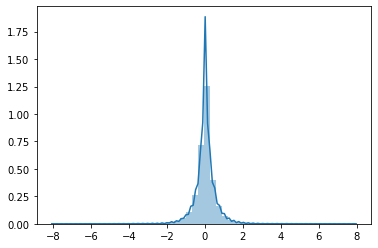

In [65]:
seaborn.distplot(dcoord_numpy[:,0])

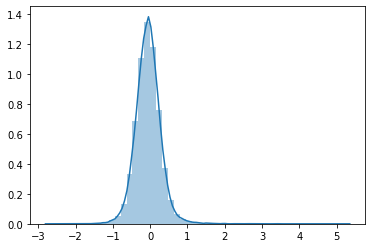

In [66]:
seaborn.distplot(dcoord_numpy[:,1])

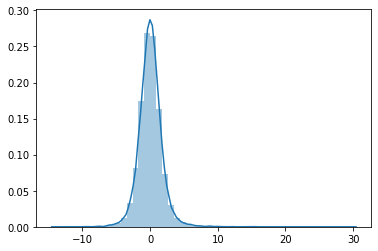

In [64]:
seaborn.distplot(dcoord_numpy[:,2])

In [50]:
print(s)

903


torch.save(model.state_dict(), "model_1601_1500.pth")
torch.save(optimizer.state_dict(), "optim_1601_1500.pth")

plt.plot([l["cls_loss"] for l in losses], alpha=0.2) #second epoch lr =1e-4
plt.plot(smooth(0.1, [l["cls_loss"] for l in losses]))
plt.ylim((0,0.5))
plt.grid()

# lr = 0.0001
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim(0,30)
plt.grid()

# lr = 0.001
plt.plot([l["loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["loss"] for l in losses]))
plt.ylim((0,7))
plt.grid()

# lr = 0.001, LeakyReLU
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

# lr = 0.001, ReLU, xavier_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

# lr = 0.001, ReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

# lr = 0.001, LeakyReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

# lr = 0.001, LeakyReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,0.1))
plt.grid()

# lr = 1E-6, LeakyReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,0.1))
plt.grid()

torch.save(model.state_dict(), "scare_model.pth")
torch.save(optimizer.state_dict(), "scare_optim.pth")

batch['orientation']

outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True)

torch.sum(torch.abs(outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True) - batch['orientation']), dim=1)

torch.sum((outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True) - batch['orientation']) ** 2, dim=1) ** 0.5

batch['label']

torch.argmax(outputs['cls_score'], dim=1)

model.backbone

nn.Sequential

import pandas as pd

df = pd.read_csv(C.TRAIN_CSV)

df.head()

import utils

train_anns = utils.load_train_annotations()

train_anns["ID_8a6e65317"]

orientations_euler = []
for k, v in train_anns.items():
    for y, p, r in zip(v["yaws"], v["pitches"], v["rolls"]):
        orientations_euler.append((-p, -y, -r))

len(orientations_euler)

from scipy.spatial.transform import rotation as R

euler_angles = self.gt["annotations"][idx][self.orientation_field]
rotation = R.from_euler("XYZ", euler_angles)
q = rotation.as_quat()

def quaternion_to_euler_angle(q):

    """Convert quaternion to euler angel.
    Input:
        q: 1 * 4 vector,
    Output:
        angle: 1 x 3 vector, each row is [roll, pitch, yaw]
    """
    w, x, y, z = q
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def euler_angles_to_quaternions(angle):
    """Convert euler angels to quaternions representation.
    Input:
        angle: n x 3 matrix, each row is [roll, pitch, yaw]
    Output:
        q: n x 4 matrix, each row is corresponding quaternion.
    """

    in_dim = np.ndim(angle)
    if in_dim == 1:
        angle = angle[None, :]

    n = angle.shape[0]
    roll, pitch, yaw = angle[:, 0], angle[:, 1], angle[:, 2]
    q = np.zeros((n, 4))

    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)

    q[:, 0] = cy * cr * cp + sy * sr * sp
    q[:, 1] = cy * sr * cp - sy * cr * sp
    q[:, 2] = cy * cr * sp + sy * sr * cp
    q[:, 3] = sy * cr * cp - cy * sr * sp

    return q

orientations_euler = np.array(orientations_euler)

orientations_quat = euler_angles_to_quaternions(orientations_euler[:, ::-1])

orientations_quat[:30]

for q in orientations_quat[:100]:
    print(q)

orientations_quat[0]

((orientations_quat[2][1:] / np.sin(np.arccos(orientations_quat[2][0]))) ** 2).sum()

((orientations_quat[2][:-1] / np.sin(np.arccos(orientations_quat[2][-1]))) ** 2).sum()

In [43]:
def rotation_to_quaternion(rotation):
    rotation = R.from_euler("XYZ", rotation)
    q = rotation.as_quat()
    return q

In [37]:
def quaternion_to_rotation(q):
    rotation = R.from_quat(q)
    ypr = rotation.as_euler("YXZ")
    return ypr

In [38]:
with open(C.TRAIN_CROPS_JSON, "r") as f:
    train_gt = json.load(f)

In [42]:
rotation_to_quaternion([0.0, 0.5, 0.5])

array([ 0.23971277, -0.06120872,  0.23971277,  0.93879128])

In [44]:
rotation_to_quaternion([0.5, 0.0, 0.5])

array([ 0.23971277, -0.06120872,  0.23971277,  0.93879128])

In [35]:
for i in range(len(train_gt['annotations'])):
#     print (train_gt['annotations'][i]['orientation'])
    q = rotation_to_quaternion(train_gt['annotations'][i]['orientation'])
    ypr = quaternion_to_rotation(q)
    assert np.linalg.norm(np.array((train_gt['annotations'][i]['orientation']) - np.array(ypr))) < 1e-7, i
#     print(ypr)
#     print('\n')